**Preparing the Graph**

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
import numpy as np
import collections
import random

**Modularity Analysis and Component Analysis**

Modularity score: 0.8349
Number of communities detected: 16
Community sizes (community: size):
  0: 352
  1: 446
  2: 423
  3: 426
  4: 535
  5: 325
  6: 118
  8: 548
  9: 73
  10: 237
  11: 25
  12: 61
  13: 206
  14: 226
  15: 19
  7: 19


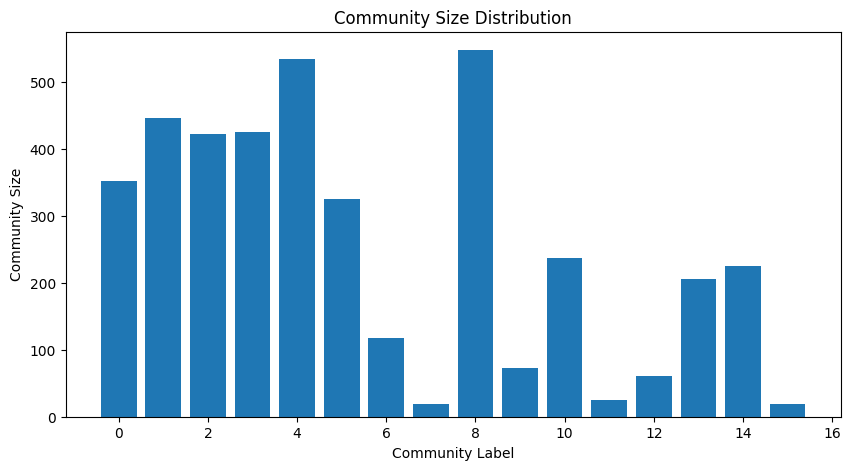

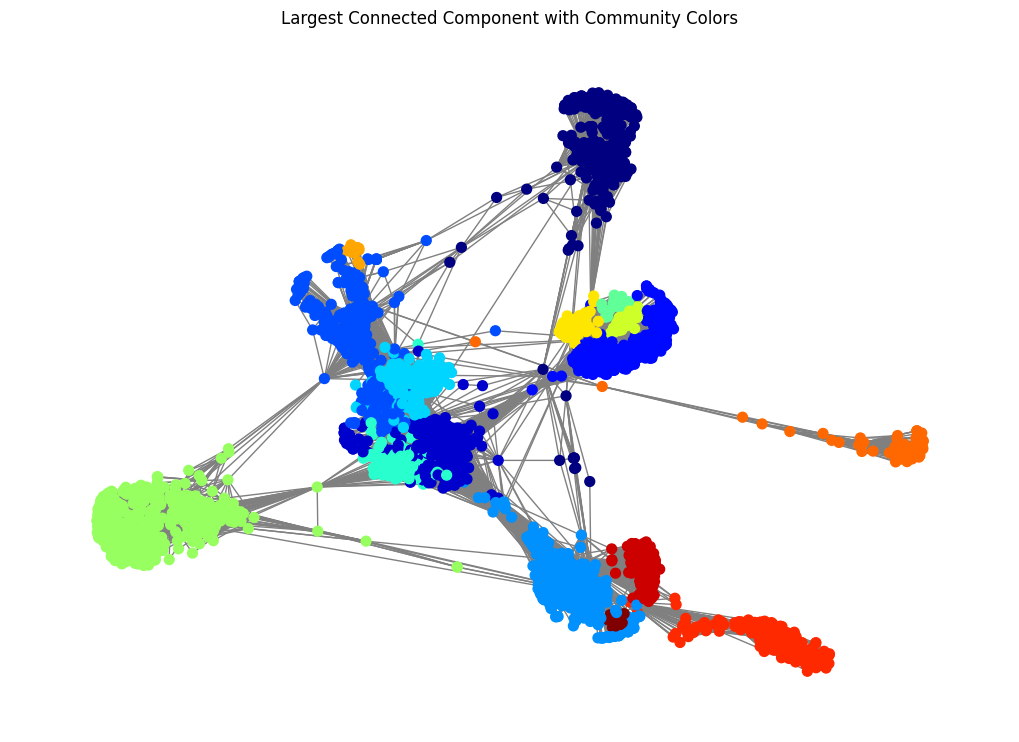

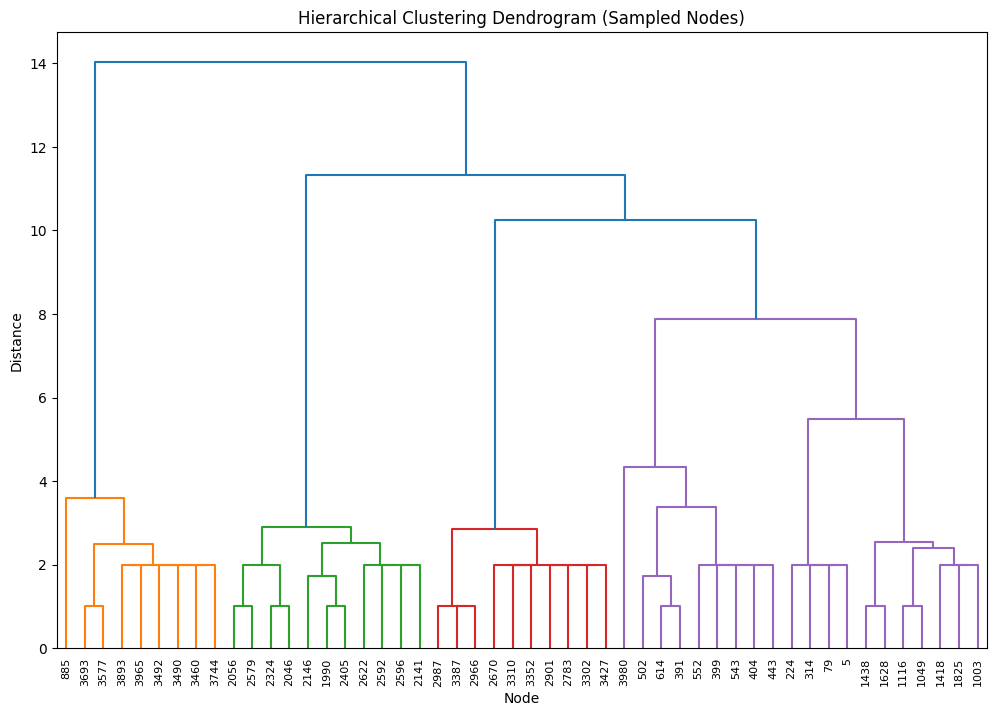

In [ ]:
# Load the graph from the given dataset
G = nx.read_edgelist('facebook_combined.txt', nodetype=int)

# Compute modularity-based partitions using the Louvain method
partition = community_louvain.best_partition(G)

# Compute and print the modularity score
modularity_score = community_louvain.modularity(partition, G)
print(f"Modularity score: {modularity_score:.4f}")

# Extract unique communities and display the number of detected communities
unique_communities = set(partition.values())
print(f"Number of communities detected: {len(unique_communities)}")

# Analyze community size distribution
community_sizes = collections.Counter(partition.values())
print("Community sizes (community: size):")
for comm, size in community_sizes.items():
    print(f"  {comm}: {size}")

# Plot the community size distribution as a bar chart
plt.figure(figsize=(10, 5))
plt.bar(list(community_sizes.keys()), list(community_sizes.values()))
plt.xlabel("Community Label")
plt.ylabel("Community Size")
plt.title("Community Size Distribution")
plt.show()

# Analyze the largest connected component of the network
largest_component = max(nx.connected_components(G), key=len)
subgraph = G.subgraph(largest_component)

# Plot the largest connected component with nodes colored by community
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(subgraph)
node_colors = [partition[n] for n in subgraph.nodes()]
nx.draw(subgraph, pos, node_color=node_colors, cmap=plt.cm.jet,
        node_size=50, edge_color="gray")
plt.title("Largest Connected Component with Community Colors")
plt.show()

# ----------------------------------------
# Hierarchical clustering on a sampled set of nodes
# ----------------------------------------
# Sample a subset of nodes from the largest connected component.
sample_size = 50
sample_nodes = random.sample(list(subgraph.nodes()), sample_size)

# Compute pairwise shortest path distances using the full largest component,
# ensuring that every pair of sample nodes is connected.
n = len(sample_nodes)
distances = np.zeros((n, n))
for i in range(n):
    for j in range(i + 1, n):
        # Compute distance in the full largest component (subgraph)
        d = nx.shortest_path_length(subgraph, source=sample_nodes[i], target=sample_nodes[j])
        distances[i, j] = d
        distances[j, i] = d

# Convert the full distance matrix to a condensed distance matrix for clustering
condensed_dist = squareform(distances)

# Perform hierarchical clustering using Ward's method
Z = linkage(condensed_dist, method='ward')

# Plot the dendrogram for the sampled nodes
plt.figure(figsize=(12, 8))
dendrogram(Z, labels=sample_nodes, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram (Sampled Nodes)")
plt.xlabel("Node")
plt.ylabel("Distance")
plt.show()



1. **Perform Centrality Analysis**
2. **Find Inter-Community Links**
3. **Analyze Community Growth Trends**



Top Influential Nodes:
      Node  Degree Centrality  Betweenness Centrality  Closeness Centrality
107    107           0.258791                0.497257              0.459699
351   1684           0.196137                0.345927              0.393606
352   1912           0.186974                0.235988              0.350947
1821  3437           0.135463                0.187540              0.314413
0        0           0.085934                0.157352              0.353343
1490  2543           0.072808                0.006411              0.291300
2154  2347           0.072065                0.002397              0.283408
1373  1888           0.062902                0.000197              0.321292
1285  1800           0.060674                0.000391              0.321599
1149  1663           0.058197                0.001751              0.339185

Inter-Community Links (first 10):
   Node A  Node B
0       0     107
1      34     348
2      34     414
3      34     428
4      58     10

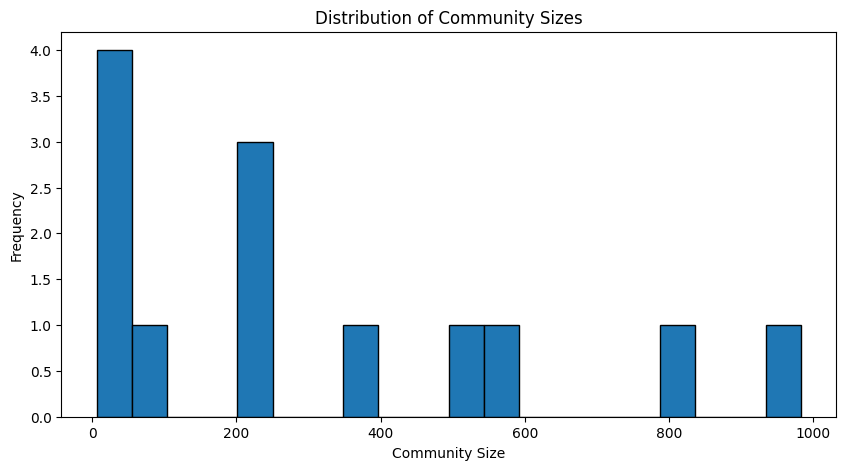

In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from networkx.algorithms import community

# Load the dataset
file_path = "facebook_combined.txt"
graph = nx.read_edgelist(file_path, nodetype=int)

# ---- CENTRALITY ANALYSIS ----
# Compute centrality measures
degree_centrality = nx.degree_centrality(graph)
approx_betweenness_centrality = nx.betweenness_centrality(graph, k=100, seed=42)  # Approximate betweenness
closeness_centrality = nx.closeness_centrality(graph)

# Create a DataFrame for centrality measures
centrality_df = pd.DataFrame({
    "Node": list(degree_centrality.keys()),
    "Degree Centrality": list(degree_centrality.values()),
    "Betweenness Centrality": [approx_betweenness_centrality.get(node, 0) for node in degree_centrality.keys()],
    "Closeness Centrality": list(closeness_centrality.values()),
})

# Sort by Degree Centrality to identify influential nodes
top_influential_nodes = centrality_df.sort_values(by="Degree Centrality", ascending=False).head(10)
print("Top Influential Nodes:")
print(top_influential_nodes)

# ---- INTER-COMMUNITY LINKS ----
# Detect communities using modularity optimization
communities = list(community.greedy_modularity_communities(graph))

# Create a mapping of node to community
node_to_community = {}
for i, comm in enumerate(communities):
    for node in comm:
        node_to_community[node] = i

# Compute inter-community edges
inter_community_edges = []
for edge in graph.edges():
    if node_to_community[edge[0]] != node_to_community[edge[1]]:
        inter_community_edges.append(edge)

# Create DataFrame for inter-community connections
inter_community_df = pd.DataFrame(inter_community_edges, columns=["Node A", "Node B"])
print("\nInter-Community Links (first 10):")
print(inter_community_df.head(10))

# ---- COMMUNITY GROWTH ANALYSIS ----
# Analyze community growth based on node degree trends
community_growth = {}

for node in graph.nodes():
    community_id = node_to_community[node]
    if community_id not in community_growth:
        community_growth[community_id] = []
    community_growth[community_id].append(graph.degree(node))

# Compute average degree per community
community_growth_stats = {
    "Community": [],
    "Average Degree": [],
    "Max Degree": [],
    "Min Degree": [],
    "Size": [],
}

for comm_id, degrees in community_growth.items():
    community_growth_stats["Community"].append(comm_id)
    community_growth_stats["Average Degree"].append(sum(degrees) / len(degrees))
    community_growth_stats["Max Degree"].append(max(degrees))
    community_growth_stats["Min Degree"].append(min(degrees))
    community_growth_stats["Size"].append(len(degrees))

# Convert to DataFrame
community_growth_df = pd.DataFrame(community_growth_stats)

# Display community growth trends
print("\nCommunity Growth Analysis (first 10):")
print(community_growth_df.head(10))

# ---- VISUALIZATION ----
# Plot the distribution of community sizes
plt.figure(figsize=(10, 5))
plt.hist(community_growth_df["Size"], bins=20, edgecolor='black')
plt.xlabel("Community Size")
plt.ylabel("Frequency")
plt.title("Distribution of Community Sizes")
plt.show()


**Hierarchical Clustering**

In [59]:
!apt-get install -y graphviz graphviz-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 29 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://a

In [61]:
!pip install pygraphviz


  Using cached pygraphviz-1.14.tar.gz (106 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pygraphviz: filename=pygraphviz-1.14-cp311-cp311-linux_x86_64.whl size=169681 sha256=f0b9624829563825d94983059c4d261d6917586fe2cfffd0a3fb10c086810298
  Stored in directory: /root/.cache/pip/wheels/9c/5f/df/6fffd2a4353f26dbb0e3672a1baf070c124a1d74a5f9318279
Successfully built pygraphviz


0 4039
1 98
2 18

Top Community Statistics:
 Community  Size  Avg Degree  Density  Clustering Coeff
         9   548   19.547445 0.035736          0.624584
         4   535   32.489720 0.060842          0.516187
         3   442   52.447964 0.118930          0.622878


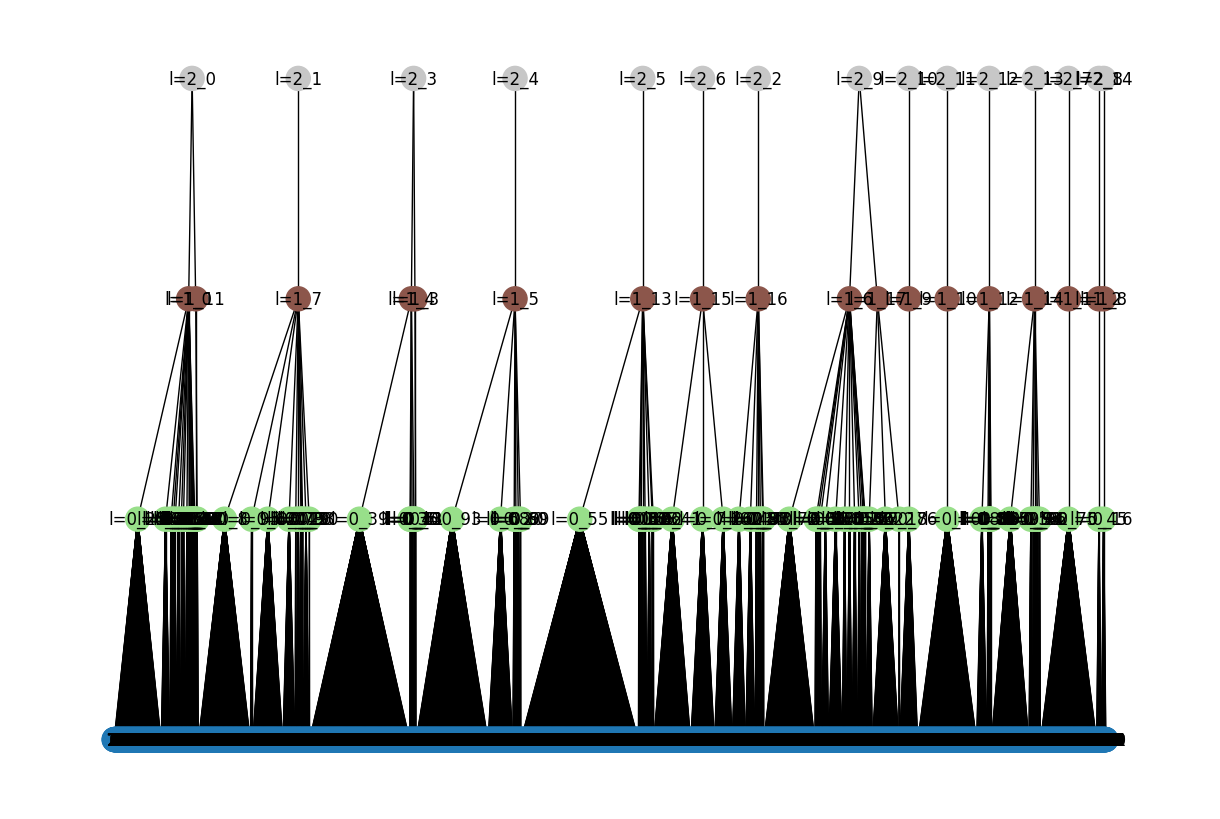

In [77]:
import matplotlib.pyplot as plt
import networkx as nx
import community.community_louvain as community
import random
import numpy as np
import pandas as pd
from networkx.drawing.nx_pydot import graphviz_layout

# Load graph from file
file_path = "facebook_combined.txt"
G = nx.read_edgelist(file_path, nodetype=int)

# Generate the Louvain dendrogram
dendrogram = community.generate_dendrogram(G)

# Create a directed graph for visualization
pg = nx.DiGraph()
last_part = None

for l, part in enumerate(dendrogram):
    print(l, len(part))
    for n, comm in part.items():
        nom = f"l={l}_{comm}"
        pg.add_node(nom, comm=comm, color=l + 1)

        if l == 0:
            pg.add_node(n, comm=comm, color=0)
            pg.add_edge(nom, n)
        else:
            pg.add_edge(nom, f"l={l-1}_{n}")
    last_part = part

# Compute final partition for community statistics
partition = community.best_partition(G)

# Extract top 3 largest communities
community_sizes = pd.Series(partition).value_counts().head(3)

# Compute statistics for top communities
community_stats = []
for comm in community_sizes.index:
    nodes = [n for n in G.nodes() if partition[n] == comm]
    subgraph = G.subgraph(nodes)
    avg_degree = np.mean([deg for _, deg in subgraph.degree()])
    density = nx.density(subgraph)
    clustering = nx.average_clustering(subgraph)

    community_stats.append({
        "Community": comm,
        "Size": len(nodes),
        "Avg Degree": avg_degree,
        "Density": density,
        "Clustering Coeff": clustering
    })

# Convert stats to DataFrame and display
df_stats = pd.DataFrame(community_stats)

print("\nTop Community Statistics:")
print(df_stats.to_string(index=False))

# Plot dendrogram visualization
plt.figure(figsize=(12, 8))
colors = list(nx.get_node_attributes(pg, 'color').values())

pos = graphviz_layout(pg, prog='dot')
nx.draw(pg, pos, with_labels=True, arrows=False, node_color=colors,
        vmin=0, vmax=len(dendrogram) + 1, cmap=plt.cm.tab20)

plt.show()


**Find k-Cliques**

In [52]:
import networkx as nx
import itertools

# Load the graph from the text file
file_path = "facebook_combined.txt"
G = nx.Graph()

with open(file_path, "r") as f:
    for line in f:
        node1, node2 = map(int, line.strip().split())
        G.add_edge(node1, node2)

# Extract a subgraph using DFS with depth limit
root_node = 1  # Starting node for the DFS
depth_limit = 4  # Depth limit to keep the subgraph manageable

dfs_tree = nx.dfs_tree(G, source=root_node, depth_limit=depth_limit)
subgraph = G.subgraph(dfs_tree.nodes)

# Find all maximal cliques in the subgraph
maximal_cliques = list(nx.find_cliques(subgraph))

def get_k_cliques(max_cliques, k):
    k_cliques_set = set()
    for clique in max_cliques:
        if len(clique) < k:
            continue
        elif len(clique) == k:
            k_cliques_set.add(tuple(sorted(clique)))
        else:
            # Generate all combinations (sub-cliques) of size k
            for combo in itertools.combinations(clique, k):
                k_cliques_set.add(tuple(sorted(combo)))
    return list(k_cliques_set)

# Find and display k-cliques for k = 3, 4, 5, and 6
for k in [3, 4, 5, 6]:
    k_cliques = get_k_cliques(maximal_cliques, k)
    print(f"{k}-cliques: {len(k_cliques)} found. Examples:")
    for example in k_cliques[:10]:
        print(example)
    print("\n")


3-cliques: 28625 found. Examples:
(118, 199, 222)
(417, 461, 553)
(56, 285, 322)
(107, 428, 1114)
(353, 391, 412)
(13, 26, 67)
(428, 431, 436)
(40, 231, 315)
(0, 79, 272)
(508, 520, 542)


4-cliques: 122175 found. Examples:
(414, 438, 465, 591)
(67, 119, 200, 248)
(348, 395, 523, 553)
(21, 56, 98, 252)
(9, 128, 252, 315)
(395, 465, 559, 669)
(348, 438, 465, 524)
(25, 40, 203, 332)
(67, 122, 213, 239)
(400, 475, 513, 553)


5-cliques: 388699 found. Examples:
(9, 26, 200, 304, 334)
(348, 370, 402, 417, 561)
(376, 432, 452, 506, 507)
(348, 412, 432, 456, 525)
(376, 412, 428, 500, 520)
(21, 26, 122, 232, 239)
(348, 430, 432, 451, 563)
(373, 391, 506, 517, 524)
(348, 370, 417, 460, 506)
(26, 98, 118, 199, 265)


6-cliques: 935376 found. Examples:
(376, 395, 515, 517, 553, 559)
(366, 402, 428, 438, 553, 559)
(376, 402, 417, 428, 506, 545)
(360, 387, 461, 507, 523, 544)
(9, 170, 271, 304, 315, 322)
(497, 506, 513, 524, 559, 561)
(376, 414, 438, 461, 553, 559)
(366, 428, 475, 492, 544, 553)
(3